In [ ]:
"""
!pip install numpy==1.25.2
!pip install torch==2.7.0
!pip install torchvision==0.22.0
!pip install gym_super_mario_bros==7.4.0
!pip install opencv-python==4.11.0.86
!pip install gym==0.26.2
!pip install nes_py==8.2.1
!pip install gymnasium==0.29.1
"""

In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
import gym_super_mario_bros
import gym
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from gym.wrappers import GrayScaleObservation,FrameStack,ResizeObservation
from gym.vector import SyncVectorEnv
import numpy as np

    # 
lr = 0.0001
_lambda_ = 0.95
gamma = 0.99
epsilon = 0.2
c1 = 0.5
c2 = 0.01
    # 
resized_observation = (90,90)
num_frames = 4
num_env = 6
skip_frame = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def make_env(): 
    class CustomEnv(gym.Wrapper): 
        # Apply skip frame method and reward shaping
        def __init__(self,env,skip):
            super().__init__(env)
            self.skip = skip
            self.total_reward = 0

        def step(self, action):
            for _ in range(self.skip):
                obs,reward,done,truncared,info = self.env.step(action)
                if info["life"] == 2:
                    self.total_reward += reward / 4
                elif info["life"] == 1:
                    self.total_reward += reward / 6
                else :
                    self.total_reward += reward / 8

                if done :
                    if info["flag_get"] :
                        self.total_reward += 100
                    else :
                        self.total_reward = -100
                    break
            return obs,round(self.total_reward,1),done,truncared,info

        def reset(self, **kwargs):
            return self.env.reset()

    x = gym_super_mario_bros.make('SuperMarioBros-v0',apply_api_compatibility=True) 
    x = ResizeObservation(x,resized_observation)  
    x = CustomEnv(x,skip_frame) 
    x = JoypadSpace(x, SIMPLE_MOVEMENT)  
    x = GrayScaleObservation(env=x,keep_dim=True)  
    x = FrameStack(x,num_frames)
    x = SyncVectorEnv(env_fns=[lambda : x] * num_env)
    return x


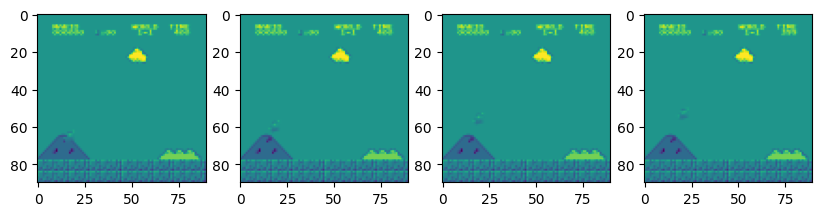

In [ ]:
# testing env output --- 
from IPython.display import clear_output
import matplotlib.pyplot as plt

env = make_env().envs[0] # call just one environment  
observations,info = env.reset()
for do in range(5):
    obs,reward,_,_,_ = env.step(4)

fig,axs = plt.subplots(1,4,figsize=(10,10))
for z in range(num_frames):
    clear_output()
    axs[z].imshow(np.array(obs[z]))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

class network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.LazyConv2d(32,1,1,0)
        self.conv2 = nn.LazyConv2d(32,3,2,2)
        self.conv3 = nn.LazyConv2d(32,3,2,2)
        self.conv4 = nn.LazyConv2d(32,3,2,2)
        self.output = nn.LazyLinear(80)

        self.policy_head = nn.LazyLinear(7)
        self.value_head = nn.LazyLinear(1)
        self.optim = Adam(self.parameters(),lr=lr)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x,start_dim=1) # -> torch.Size([32, 169])
        x = F.relu(self.output(x))
        policy_output = self.policy_head(x)
        value_output = self.value_head(x)
        return F.softmax(policy_output,-1),value_output

model = network() 
model.forward(torch.rand((1,4,90,90),dtype=torch.float))
clear_output()


In [ ]:
import random
from torch.distributions import Categorical
import gc

class Memory:
    def __init__(self,env : SyncVectorEnv):
        self.network = model
        self.env = env
        self.gamma = gamma
        self._lambda_ = _lambda_
        self.data = []
        self.pointer = 0
    
    def rollout(self,batchsize):
        self.clear()
        _observation,info = self.env.reset()
        observation = torch.from_numpy(np.array(_observation)).squeeze()
    
        with torch.no_grad(): 
            for _ in range(batchsize):  
                policy_output , value = self.network.forward(observation.to(device,dtype=torch.float))
                distribution = Categorical(policy_output)
                action = distribution.sample()
                prob = distribution.log_prob(action)
       
                state,reward,done,_,_ = self.env.step(action.tolist())
                
                if done.any(): # reset each done env or get an error haha !
                    done_idx = np.where(done == True)[0] 
                    for i in done_idx:
                        _observation[i],info[i] = self.env.envs[i].reset()

                self.data.append([state,torch.tensor(reward),value,prob,action,done])

        _,rewards,values,_,_,_ = zip(*self.data) # compute advantages 
        _rewards = torch.stack(rewards).to(device)
        _values = torch.stack(values).squeeze() 
        zeros = torch.zeros(1,_values.shape[-1],device=device)
        _values = torch.cat([_values,zeros])
  
        advantages = torch.zeros_like(_rewards,device=device,dtype=_values.dtype)
        gae = 0.0
        for n in reversed(range(len(_rewards))):
            td = _rewards[n] + self.gamma * _values[n+1] - _values[n] # temporal difference
            gae = td + (self._lambda_ * self.gamma * gae) 
            advantages[n] = gae

        for data,item in zip(self.data,advantages): # append advantages to data
            data.append(item)
        random.shuffle(self.data) 

    def sample(self,number):
        output = self.data[self.pointer:self.pointer+number]
        self.pointer+=number
        states,rewards,values,logProb,actions,done,advantages = zip(*output)
        return states,actions,rewards,values,logProb,advantages,done

    def clear(self):
        self.data = []
        self.pointer = 0
        gc.collect()
        torch.cuda.empty_cache()


In [ ]:
torch.autograd.set_detect_anomaly(True)
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

class agent:
    def __init__(self,):
        self.env = make_env()
        self.memory = Memory(self.env)
        self.network = model
        self.writter = SummaryWriter("./")

    def save(self,k):
        checkpoint = {
            "model_state" : self.network.state_dict(),
            "optim_state" : self.network.optim.state_dict(),
            "lr" : lr,
            "c2" : c2,
            "epsilon" : epsilon
        }
        torch.save(checkpoint,f"./mario{k}")
    
    def log(self,reward,total_loss,loss_policy,loss_critic,entropy):
        self.writter.add_scalar("main/reward",reward)
        self.writter.add_scalar("main/total loss",total_loss)
        self.writter.add_scalar("main/loss policy",loss_policy)
        self.writter.add_scalar("main/loss critic",loss_critic)
        self.writter.add_scalar("main/entropy",entropy)
  
    def train(self,num_game,batchsize,minibatch,optim_step):
        for traj in tqdm(range(num_game),total = num_game):
            self.memory.rollout(batchsize)

            for _ in range(batchsize//minibatch):
                states,actions,rewards,values,old_log_prob,advantages,done = self.memory.sample(minibatch)    
                _rewards = torch.mean(torch.stack(rewards))
                self.writter.add_scalar("main/reward",_rewards)

                for _ in range(optim_step): 
                    _advantages = torch.stack(advantages)
                    _values = torch.stack(values).squeeze()
                    _old_log_prob = torch.stack(old_log_prob)
                    
                    vtarget = _advantages + _values
                    loss_critic = torch.mean(torch.pow((_values-vtarget),2)) 
                     
                    _states = [torch.from_numpy(np.array(lazy_frame)).squeeze() for lazy_frame in states]
                    stacked_states = torch.stack(_states) # -> [minibatch, num_env, stacked_frames, image_shape]
                    flat_states = torch.flatten(stacked_states,0,1).to(device,dtype=torch.float) # -> [minibatch * num_env, stacked_frames, image_shape]
                    p_output,_ = self.network.forward(flat_states)
                    policy_output = p_output.view(minibatch,num_env,7)
                    dist = Categorical(policy_output)   
                    stacked_actions = torch.stack(actions)  
                    new_log_prob = dist.log_prob(stacked_actions)

                    _entropy = -(policy_output * torch.log(policy_output + 1e-10)).sum(dim=2)
                    entropy = _entropy.sum(dim=1).mean()

                    ratio = torch.exp(new_log_prob - _old_log_prob)
                    proxy1 = ratio * _advantages
                    proxy2 = torch.clamp(ratio ,1-epsilon,1+epsilon) * _advantages
                    loss_policy = -torch.mean(torch.min(proxy1,proxy2))  
        
                    total_loss = loss_policy + (c1*loss_critic) - (c2*entropy)
    
                    self.network.optim.zero_grad()
                    total_loss.backward(retain_graph=True)
                    torch.nn.utils.clip_grad_norm_(self.network.parameters(), 0.5)
                    self.network.optim.step()
                    
            self.log(_rewards,total_loss,loss_policy,loss_critic,entropy)
            if traj % 50 == 0 : # save every ...k steps
                self.save(traj)
                
        self.save("_end")

test = agent()
test.train(num_game=20,batchsize=20,minibatch=10,optim_step=2)